In [14]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROOQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="llama-3.1-8b-instant",temperature=0.7)

result=llm.invoke("Howdy")
result

AIMessage(content='Howdy back atcha. What can I do for ya today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 37, 'total_tokens': 52, 'completion_time': 0.763241351, 'prompt_time': 0.322578681, 'queue_time': 0.215650309, 'total_time': 1.085820032}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_55d70a61e4', 'finish_reason': 'stop', 'logprobs': None}, id='run--1f25cf73-e77f-40c5-ac17-90888a167fa0-0', usage_metadata={'input_tokens': 37, 'output_tokens': 15, 'total_tokens': 52})

In [15]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

#Schema for structured output to use a routing logic
class Route(BaseModel):
    step: Literal["poem","story","joke"]=Field(
        description="The next step in the routing process")

# Augment LLM with Structured Output
router=llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str
    
# Nodes
def llm_call_story(state:State):
    """Write a story"""
    
    result=llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_joke(state:State):
    """Write a joke"""
    
    result=llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_poem(state:State):
    """Write a poem"""
    
    result=llm.invoke(state["input"])
    return {"output":result.content}


def llm_call_router(state:State):
    """Route the input to appropriate node"""
    
    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke or poem based on the users request."
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}

# Condtion edge function to route to the appropriate node

def route_decision(state:State):
    # Return the node name you want to visit next
    if state["decision"]=="story":
        return "llm_call_story"
    elif state["decision"]=="joke":
        return "llm_call_joke"
    elif state["decision"]=="poem":
        return "llm_call_poem"   

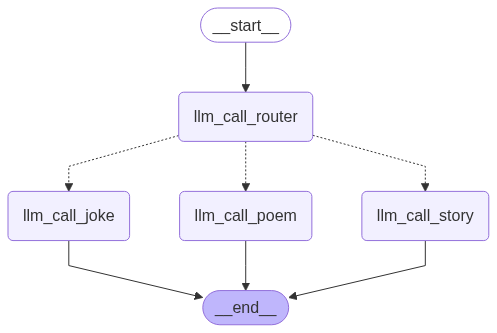

In [16]:
# Build Graph
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

#Add nodes
graph.add_node("llm_call_story",llm_call_story)
graph.add_node("llm_call_joke",llm_call_joke)
graph.add_node("llm_call_poem",llm_call_poem)
graph.add_node("llm_call_router",llm_call_router)

#Add edges
graph.add_edge(START,"llm_call_router")
graph.add_conditional_edges(
                            "llm_call_router"
                            ,route_decision,
                            # Name returned by the route_decision : Name of next node to visit
                            {
                                "llm_call_story":"llm_call_story",
                                "llm_call_joke":"llm_call_joke",
                                "llm_call_poem":"llm_call_poem"
                            }
                            )
graph.add_edge("llm_call_story",END)
graph.add_edge("llm_call_joke",END)
graph.add_edge("llm_call_poem",END) 

graph=graph.compile()
graph_image=graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [17]:
state=graph.invoke({"input":"Write me a story"})
state

{'input': 'Write me a story',
 'decision': 'story',
 'output': 'Once upon a time, in a small village nestled in the rolling hills of England, there lived a young girl named Emily. She was a dreamer, with a heart full of wonder and a mind full of curiosity. Emily loved nothing more than to spend her days exploring the countryside, discovering hidden streams and secret meadows, and watching the clouds roll by.\n\nOne day, while wandering through the village, Emily stumbled upon a small, mysterious shop. The sign above the door read "Curios and Wonders," and the windows were filled with a dazzling array of strange and exotic objects. Emily\'s eyes widened as she pushed open the door and stepped inside.\n\nThe shop was dimly lit, with shelves upon shelves of peculiar items. There were vintage dolls, antique clocks, and rare books, each one more fascinating than the last. Emily wandered the aisles, running her fingers over the intricate carvings on a wooden cabinet, and marveling at the glo

In [18]:
state=graph.invoke({"input":"Write a poem"})
state

{'input': 'Write a poem',
 'decision': 'poem',
 'output': '"Whispers of the Wind"\n\nIn twilight\'s hush, where shadows play,\nThe wind whispers secrets, night and day.\nA gentle breeze that stirs the trees,\nAnd rustles leaves with soothing ease.\n\nThe stars above, a twinkling sea,\nReflect the dreams that dance in me.\nThe moon, a glowing crescent smile,\n Illuminates the path, all the while.\n\nIn quiet moments, I listen close,\nTo the wind\'s tales of love and loss.\nOf distant lands and memories past,\nAnd the whispers of a love that will forever last.\n\nThe wind\'s melody, a lullaby sweet,\nEchoes through my soul, a gentle beat.\nA reminder of life\'s ebb and flow,\nAnd the beauty that only nature can show.\n\nSo let the wind whisper secrets to me,\nAnd let its melodies set my soul free.\nFor in its whispers, I find peace and rest,\nAnd a connection to the world, at its best.'}

In [19]:
state=graph.invoke({"input":"Write a funny joke that is most familiar"})
state

{'input': 'Write a funny joke that is most familiar',
 'decision': 'joke',
 'output': 'Here\'s a classic one:\n\n"Why was the math book sad? Because it had too many problems."\n\nThis joke is a play on words, using the phrase "too many problems" to refer both to math equations and personal issues, making it a well-known and relatable joke.'}